# SOPHY Database
### Southern Ocean Phytoplankton Database
- Made by Ayush Nag and Hannah-Joy Warren (add others)
- UW Oceanography (add other credits)

# Environment and package setup
Create new environment
- Miniconda is recommended

To explore the data in table form through a web browser (Datasette)
- ```conda create -n sophyvenv datasette pandas jupyter tqdm```

To visualize the data using a Jupyter Notebook
- ```conda create -n sophyvenv geopandas cartopy jupyter seaborn tqdm```
# Import packages

In [1]:
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy
import pandas as pd
from pandas import DataFrame
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import numpy as np
import geolabel
import geopandas as gpd
import pyproj
from shapely.ops import transform
from matplotlib.colors import ListedColormap
import matplotlib.path as mpath
from tqdm import tqdm

# Initialization script
- Builds SOPHY database
- Outputs sophy.db file in virtual environment
- Should be run ONLY once

## Option 1: SQLite Database
- Builds local .db file
- Recommended if you are familiar with SQL
- Sample queries shown in cells below
- Outputs result of queries as DataFrame

In [20]:
print('Building the SOPHY database')
con = sqlite3.connect('sophy.db')
dfs = pd.read_excel('../data/out/sophy.xlsx', index_col=0, sheet_name=None)
for table, df in tqdm(dfs.items()):
    df.to_sql(table, if_exists='replace', con=con)
print('SOPHY build successful!')

Building the SOPHY database


  0%|          | 0/4 [00:00<?, ?it/s]

SOPHY build successful!


## Option 2: Pandas DataFrame
- Read data directly as a DataFrame

In [ ]:
data = pd.read_excel('../data/out/sophy.xlsx', index_col=0, sheet_name='sample')

# Query the SOPHY Database.
- Queries can be formatted using sophysql.query()
- Output is a pandas DataFrame
- General template and sample queries are provided below

In [3]:
# tables = [sample, occurrence, taxonomy, microscopy]
# Query loads all lat, lon from sample and occurrence tables
data: DataFrame = pd.read_sql("select latitude, longitude from sample UNION ALL select latitude, longitude from occurrence;", con=con)
data
# data.to_csv("sample1.csv", index=False)

,latitude,longitude
0,-64.83333,-64.05167
1,-64.83333,-64.05167
2,-64.83333,-64.05167
3,-64.83333,-64.05167
4,-64.83333,-64.05167
...,...,...
68050,-57.00000,170.00000
68051,-57.00000,170.00000
68052,-57.00000,170.00000
68053,-57.00000,170.00000


In [16]:
# Entries in sample grouped by month and year
data = pd.read_sql("select count(*) as entries, strftime('%Y-%m', timestamp) as year_month from sample group by year_month", con=con)
data

,entries,year_month
0,752,1991-11
1,1835,1993-01
2,383,1993-02
3,212,1993-03
4,2060,1993-04
...,...,...
56,27,2018-02
57,378,2019-01
58,31,2019-02
59,227,2020-01


In [15]:
# sectors: ['Ross', 'BA', 'Weddell', 'Indian', 'WPO']
data = pd.read_sql("select * from sample where sample.percent_diatom > 0.8 and sample.sector == 'BA';", con=con)
data

,index,id,source_name,cruise,latitude,longitude,timestamp,front_zone,sector,percent_phaeo,...,chl_a,salinity,temperature,mld,par,nitrate,nitrite,phosphate,silicate,extra_json
0,177,178,lter,PD91-09,-64.93333,-64.46667,1991-11-11 19:27:00,SIZ,BA,0.000000,...,0.1870,33.8400,-1.6479,None,None,27.200,0.000,2.400,43.200,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
1,1068,1069,lter,PD93-01,-64.08735,-66.55957,1993-01-11 23:30:00,SIZ,BA,0.000000,...,NaN,33.8560,1.3376,None,None,NaN,NaN,NaN,NaN,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
2,4254,4255,lter,NBP93-02,-66.25417,-67.34000,1993-04-17 05:03:00,SIZ,BA,0.105354,...,0.8994,34.1180,-0.5270,None,None,NaN,0.080,2.169,80.890,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
3,4329,4330,lter,NBP93-02,-65.75100,-68.58733,1993-04-18 03:30:00,SIZ,BA,0.167510,...,0.0045,34.0150,-1.1278,None,None,NaN,0.167,2.171,74.920,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
4,6986,6987,lter,PD94-01,-66.53872,-67.40968,1994-01-29 19:46:00,SIZ,BA,0.000000,...,0.0332,34.1550,-0.2490,None,None,NaN,0.900,NaN,33.700,"{""Alloxanthin"":0.0,""BetaCarotene"":0.0,""BottleN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,28969,28970,lter,LMG20-01,-65.87762,-68.28263,2020-01-13 14:50:00,SIZ,BA,0.000703,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,"{""Alloxanthin"":0.0,""AlphaCarotene"":0.0,""Anther..."
1128,29030,29031,lter,LMG20-01,-67.11498,-71.53319,2020-01-20 11:53:00,SIZ,BA,0.008699,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,"{""Alloxanthin"":0.0,""AlphaCarotene"":0.0,""Anther..."
1129,29107,29108,lter,LMG20-01,-66.51472,-69.90954,2020-01-31 22:30:00,SIZ,BA,0.021937,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,"{""Alloxanthin"":0.009320282,""AlphaCarotene"":0.0..."
1130,29259,29260,lter,LMG07-01,-63.58978,-67.73552,2007-01-12 12:49:00,ASZ,BA,0.137496,...,0.4650,33.7595,2.3437,None,None,20.907,0.229,1.330,4.472,"{""Alkalinity1"":2287.2,""Alkalinity2"":2284.8,""Al..."


In [ ]:
# add other sample queries
# TODO: Make SQL Views for commonly used queries
# - filter by front and sector
# - filter by year range
# - view only a certain month over time

# Plot setup

In [4]:
def so_map_ax() -> plt.axes:
    map_proj = ccrs.SouthPolarStereo()
    fig = plt.figure(figsize=[12, 12])  # inches
    ax = plt.subplot(projection=map_proj)
    ax.set_extent([-180, 180, -90, -39.4], ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    ax.add_feature(cartopy.feature.LAND)
    ax.gridlines(xlocs=[-130, -60, 20, 90, 160], draw_labels=True)
    theta  = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
    verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    return ax

def make_sectors() -> gpd.GeoDataFrame:
    project = pyproj.Transformer.from_crs(ccrs.PlateCarree(), ccrs.SouthPolarStereo(), always_xy=True).transform
    # Sectors are shapefiles
    s1 = transform(project, Polygon(zip(np.append(np.linspace(start=-130, stop=-60, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s2 = transform(project, Polygon(zip(np.append(np.linspace(start=-60, stop=20, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s3 = transform(project, Polygon(zip(np.append(np.linspace(start=20, stop=90, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s4 = transform(project, Polygon(zip(np.append(np.linspace(start=90, stop=160, num=1000), 0), np.append(np.full(1000, -30), -90))))
    s5 = transform(project, Polygon(zip(np.append(np.append(np.linspace(start=160, stop=180, num=500), np.linspace(start=-180, stop=-130, num=500)), 0), np.append(np.full(1000, -30), -90))))
    s: list = [s1, s2, s3, s4, s5]
    return gpd.GeoDataFrame(geometry=s, crs=ccrs.SouthPolarStereo())

def my_map() -> ListedColormap:
    # Color shades
    greens  = ['#659222', '#7EA640', '#97BB5E', '#AFCF7D', '#C8E49B', '#E1F8B9']
    yellows = ['#B37707', '#CC8E1B', '#E6A52E', '#FFBC42', '#FFCE75', '#FDE3B1']
    maroons = ['#8F2D56', '#A24C70', '#B66A8B', '#C989A5', '#DDA7C0', '#F0C6DA']
    purples = ['#503E8F', '#6E5EA3', '#8B7FB7', '#A99FCA', '#C6C0DE', '#E4E0F2']
    teals   = ['#218380', '#459B99', '#69B2B3', '#8DCACC', '#B1E1E6', '#D5F9FF']
    greens.reverse(), yellows.reverse(), maroons.reverse(), purples.reverse(), teals.reverse()
    # List of all colors
    color_palette = greens + yellows + maroons + purples + teals
    # Make color palette
    return ListedColormap(sns.color_palette(color_palette).as_hex())

# Plot query on Southern Ocean
- Includes zones and sectors
- Modify the data variable (DataFrame) with queries above and plot here

<GeoAxesSubplot: >

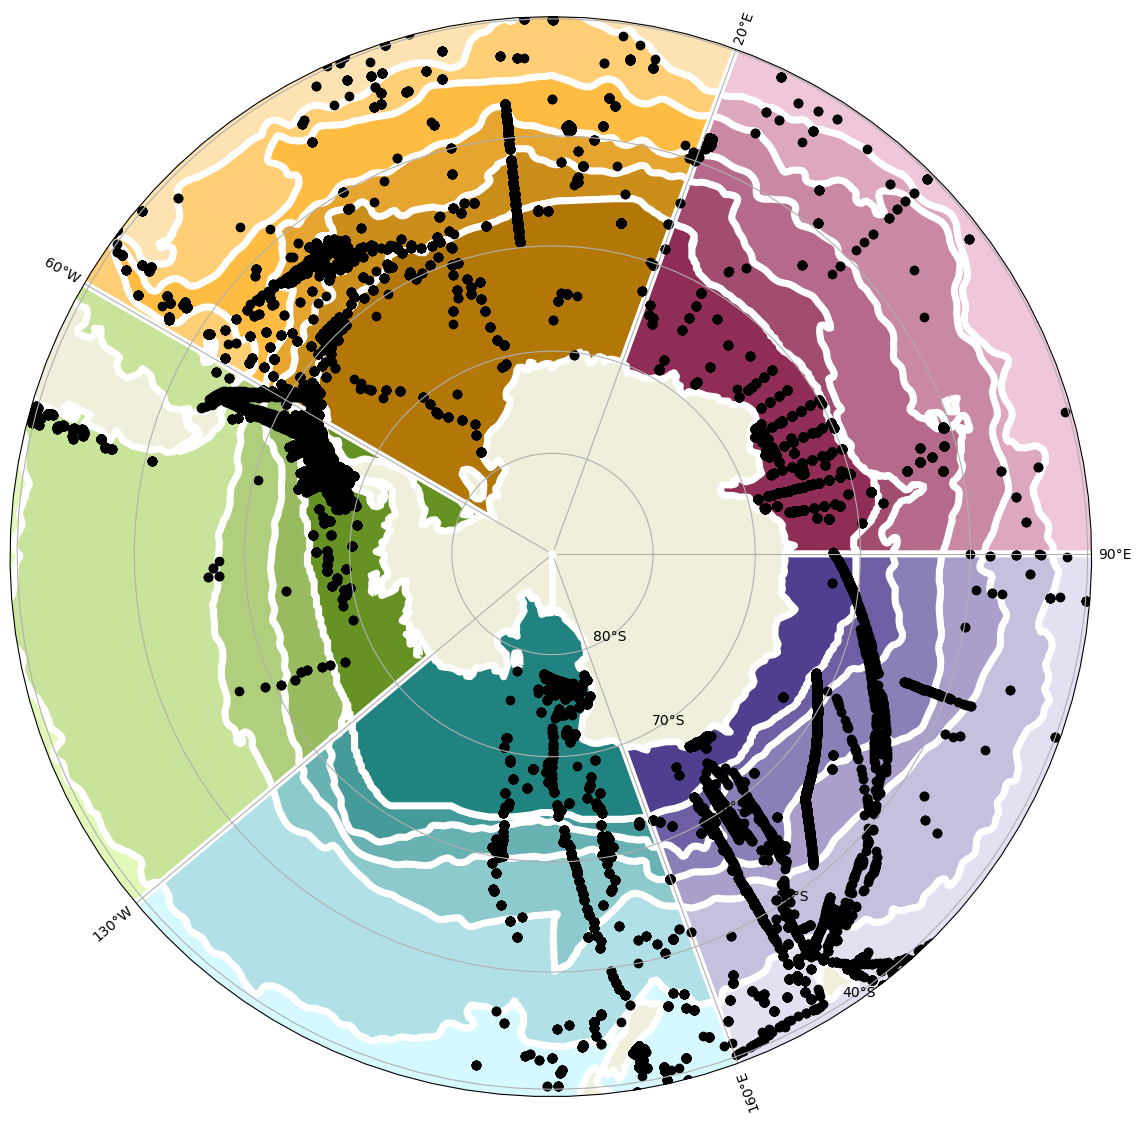

In [10]:
# Generate Southern Ocean plot, GeoDataFrame of sectors, and colormap
ax, sectors, colormap = so_map_ax(), make_sectors(), my_map()
# Get Southern Ocean zones as GeoDataFrame (with shapefiles)
zones: gpd.GeoDataFrame = gpd.read_file(geolabel.zones_shapefile).to_crs(crs=ccrs.SouthPolarStereo())
# Overlay zones and sectors
res = zones.overlay(sectors, how='intersection', keep_geom_type=True)
res.plot(ax=ax, cmap=colormap, edgecolor='w', legend=True, linewidth=5)
# Plot queried data
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=ccrs.PlateCarree())
data_gdf.to_crs(crs=ccrs.SouthPolarStereo(), inplace=True)
data_gdf.plot(ax=ax, color='k')

In [4]:
con.close()
# color by type of data, data source, year, season
#   - option in plotting function
# update gridline labels to align with sectors
# red=chemtax, blue=micro, purple=both

# show by type of data available

# filter down area
# Two scatter plots for chemtax and microscopy vs. time
#   - sort by time to draw line
#   - try chemtax one first; test all chemtax, otherwise do phaeo, diatoms, other
# zoom to fit data (with padding for visibility)

``` conda install -c conda-forge datasette```
Change directory to sophy/sophy
``` datasette sophy.db -o```